# Introduction

A portfolio investment company wants to establish a robust intelligent system to aid our value investing efforts using stock market data based on intrinsic value of companies rather than daily market volatility. 

The data provided below was downloaded from the `yfinance` library and report the actual stock data from Square Enix Ltd., a famous digital entertainment company, as a way to train and test a model the is able to predict capital returns.

This projects has several goals:

1. Predict stock price valuations on a daily, weekly and monthly basis.
2. Recommend BUY, HOLD, SELL decisions.
3. Maximize capital returns, and minimize losses and HOLD period.

The success metric will primarily base on Bollinger Bands to measure effectiveness of the model.

## Libraries

In [217]:
# basic libraries
import pandas as pd
import numpy as np
from warnings import catch_warnings, filterwarnings

# data visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,9), 'figure.dpi':120})
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode'
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# time-series algorithms
import yfinance as yf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm # for Auto ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from prophet import Prophet

# stats and metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# LSTM architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

# Retrieving data

In [2]:
ticker = "SQNXF"

data = yf.Ticker(ticker)
data.info

{'address1': 'Shinjuku Eastside Square',
 'address2': '6-27-30 Shinjuku Shinjuku-ku',
 'city': 'Tokyo',
 'zip': '160-8430',
 'country': 'Japan',
 'phone': '81 3 5292 8000',
 'website': 'https://www.hd.square-enix.com',
 'industry': 'Electronic Gaming & Multimedia',
 'industryKey': 'electronic-gaming-multimedia',
 'industryDisp': 'Electronic Gaming & Multimedia',
 'sector': 'Communication Services',
 'sectorKey': 'communication-services',
 'sectorDisp': 'Communication Services',
 'longBusinessSummary': 'Square Enix Holdings Co., Ltd. operates in the content and service businesses in Japan and internationally. It operates through Digital Entertainment Business, Amusement Business, Publishing Business, and Rights Property Business. The company plans, develops, sells, and manages digital entertainment content primarily in the form of computer games. It is also involved in the operation of amusement facilities; and planning, development, manufacture, sale, and rental of arcade game machines

## Data splitting

In [3]:
train_start = "2021-01-01"
train_end = "2023-12-31"

test_start = '2024-01-01'
test_end = '2024-05-05'

train_data = yf.download(ticker, start=train_start, end=train_end).reset_index()
test_data = yf.download(ticker, start=test_start, end=test_end).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
train_data.info(), train_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       753 non-null    datetime64[ns]
 1   Open       753 non-null    float64       
 2   High       753 non-null    float64       
 3   Low        753 non-null    float64       
 4   Close      753 non-null    float64       
 5   Adj Close  753 non-null    float64       
 6   Volume     753 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 41.3 KB


(None,
 Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64)

Here's some (pretty summary) explanation of the variables:

1. `Date`: date of reference;
2. `Open`: the price of the stock when the market opened on this day;
3. `High`: a stock's highest trading price for the day;
4. `Low`: a stock's lowest trading price for the day;
5. `Close`: the price of the stock when the market closed on this day;
6. `Adj Close`: the closing price after adjustments for all applicable splits and dividend distributions;
7. `Volume`: the ranges that the stock has traded in the given time period, and how many shares have traded hands today.

For this project, I will be specifically looking at `Adj Close` as the dependent variable to predict. 

In [5]:
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,58.869999,58.869999,58.869999,58.869999,56.556213,600
1,2021-01-05,58.869999,58.869999,58.869999,58.869999,56.556213,0
2,2021-01-06,58.200001,58.200001,58.200001,58.200001,55.912552,200
3,2021-01-07,57.849998,57.849998,57.849998,57.849998,55.576302,100
4,2021-01-08,57.849998,57.849998,57.849998,57.849998,55.576302,0


In [6]:
train_data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,753.000000,753.000000,753.000000,753.000000,753.000000,753.000000
mean,48.126215,48.195963,48.053094,48.126653,46.962416,674.634794
std,7.642912,7.649951,7.590828,7.612237,7.096994,4456.459799
min,32.720001,33.000000,32.599998,32.900002,32.412437,0.000000
25%,44.610001,44.630001,44.610001,44.630001,43.884438,0.000000
50%,47.310001,47.439999,47.310001,47.349998,46.401665,0.000000
75%,53.290001,53.400002,52.880001,52.900002,51.282410,300.000000
max,68.419998,68.419998,68.309998,68.309998,65.625198,89100.000000


## Data visualization (train set only)

In [7]:
px.area(train_data, x='Date', y='Adj Close')

In [8]:
px.box(train_data, y='Adj Close')

<Figure size 1080x1080 with 0 Axes>

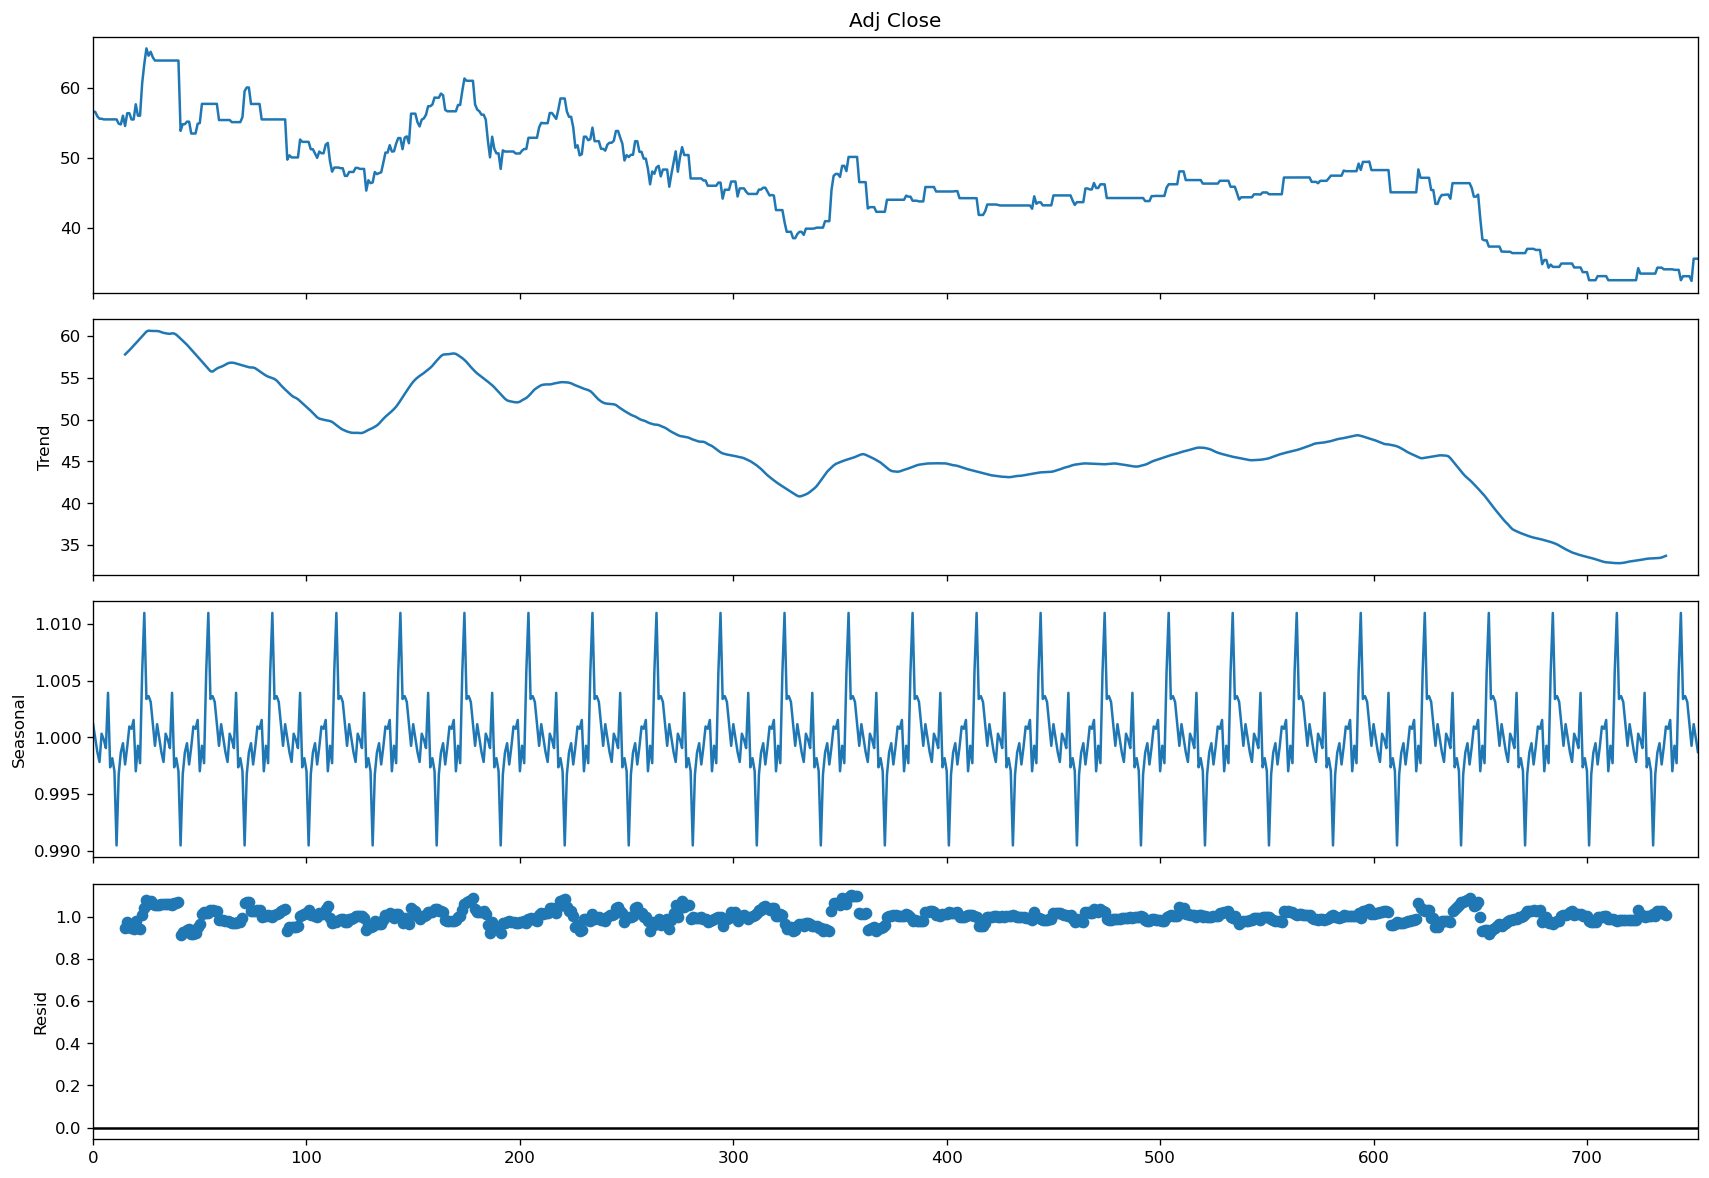

In [9]:
decomposition = seasonal_decompose(train_data['Adj Close'], model='multiplicative', period=30) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 10)

In [10]:
def DickeyFuller(variable):    
  adft = adfuller(variable, autolag='AIC') #output for test will return the values without defining what they are, so we will have to manually write what values are
  adft_df = pd.Series(adft[0:4],index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
  for key,values in adft[4].items():
      adft_df['critical value (%s)'%key] =  values
  print("Results of Dickey-Fuller test\n")
  print(adft_df)  

  p_value = adft_df[1]
  if p_value <= .05:
     print("\nWith p < .05, we reject the null hypothesis and conclude that the data is stationary.")
  else: 
     print("\nWith p > .05, we fail to reject the null hypothesis, and conclude that the data is non-stationary.")

DickeyFuller(train_data['Adj Close'])

Results of Dickey-Fuller test

Test Statistics                 -1.790601
p-value                          0.385138
No. of lags used                 0.000000
Number of observations used    752.000000
critical value (1%)             -3.439076
critical value (5%)             -2.865391
critical value (10%)            -2.568821
dtype: float64

With p > .05, we fail to reject the null hypothesis, and conclude that the data is non-stationary.


# Modelling

I will use the data above to test the effectiveness of the following 6 time-series algorithms:

1. autoregressive (AR)
2. Autoregressive Integrated Moving Average (ARIMA)
3. Seasonal Autoregressive Integrated Moving Average (SARIMA)
4. Exponential Smoothing (ES)
5. Prophet
6. LSTM

## Autoregression (AR)

Autoregression is a time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very simple idea that can result in accurate forecasts on a range of time series problems. 

An autoregression model makes an assumption that the observations at previous time steps are useful to predict the value at the next time step (autocorrelation). We can use statistical measures to calculate the correlation between the output variable and values at previous time steps at various different lags. The stronger the correlation between the output variable and a specific lagged variable, the more weight that autoregression model can put on that variable when modeling.

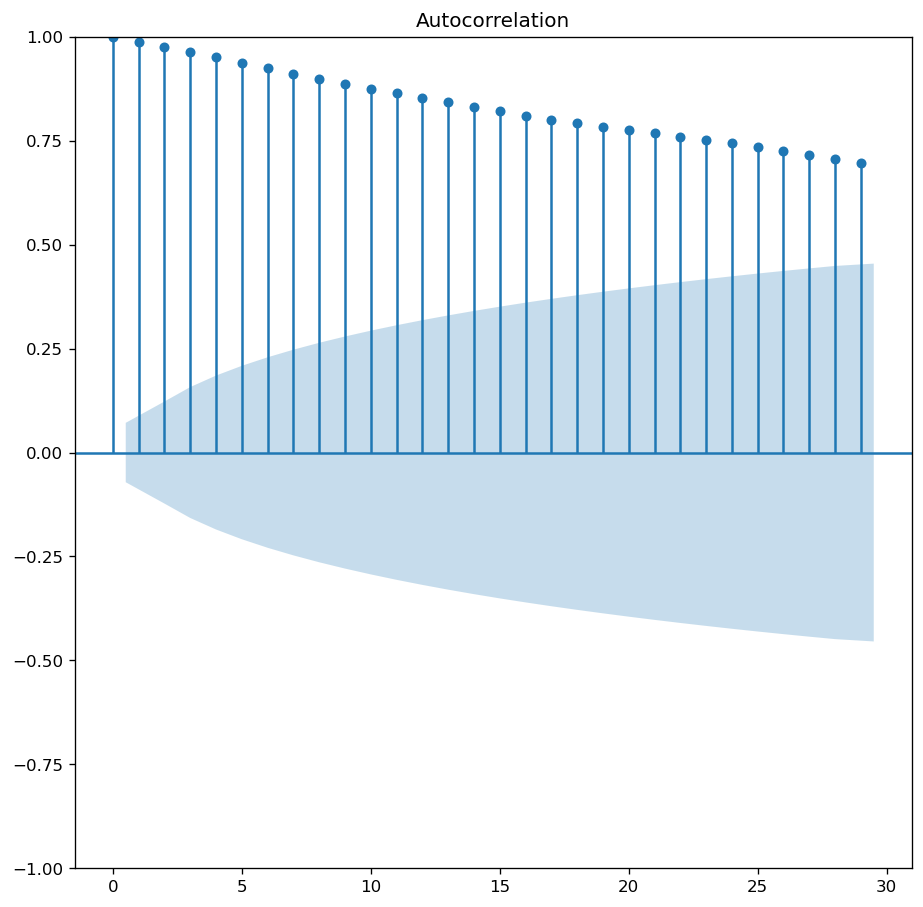

In [128]:
plot_acf(train_data['Adj Close']);

Here we can see that each time point is highly correlated with the previous one (lag).

### Model and evaluation

RMSE: 3.47


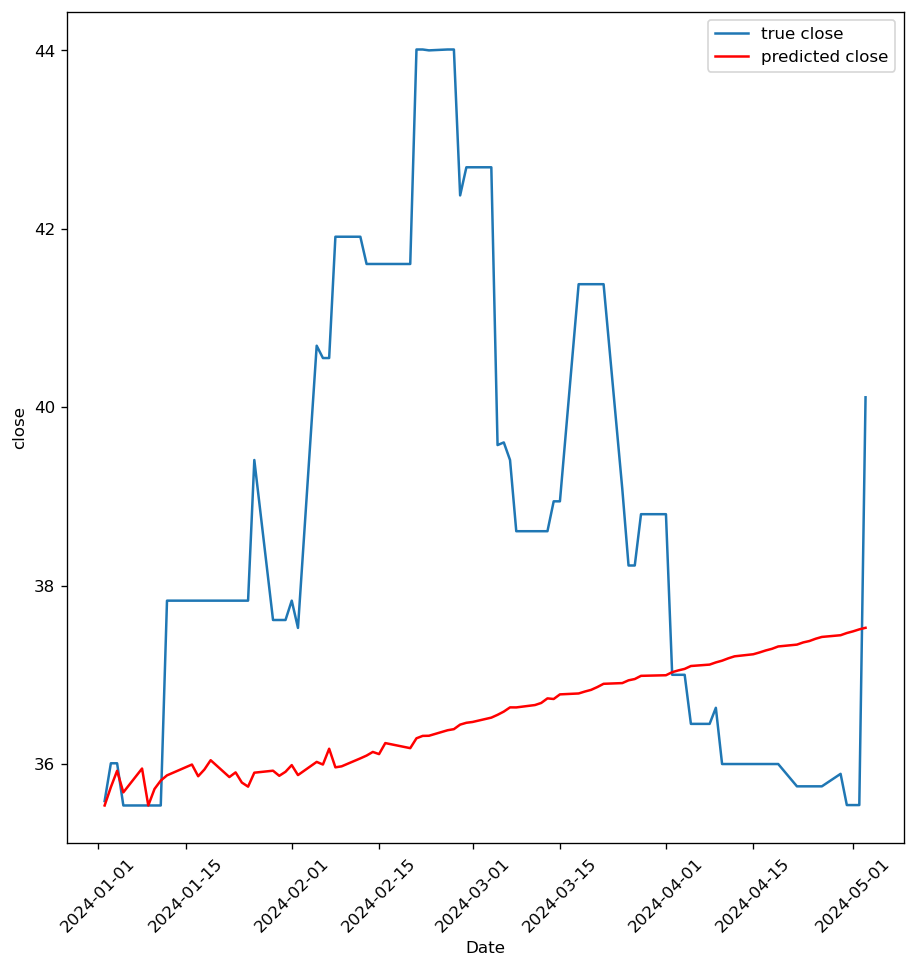

In [137]:
ar_model = AutoReg(train_data['Adj Close'], lags=30)
ar_fit = ar_model.fit()

# make predictions
ar_predictions = ar_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# calculate RMSE
ar_rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], ar_predictions))

print("RMSE: %.2f" % (ar_rmse))

# plotting
plt.plot(test_data['Date'], test_data['Adj Close'], label='true close')
plt.plot(test_data['Date'], ar_predictions, color='red', label='predicted close')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('close')
plt.show()

As we can see above, the AR model does not do a good job at predicting the close price, which suggests that a more sophisticated model is needed for our case.

## Autoregressive Integrated Moving Average (ARIMA)

Auto Regressive Integrated Moving Average, ARIMA, models are among the most widely used approaches for time series forecasting. It is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values.

An ARIMA model is characterized by 3 terms: 

- the autoregressive (AR) component, which captures the relationship between the current observation and a specified number of lagged observations from the past. It is represented by the `p` term.
- the differencing (I) component, which is used to transfor a non-stationary time series into a stationary one. Stationarity is the property of a time series to remain constant over time. The `d` tem is the number of differencing required to remove seasonality or trends, and make the time series stationary.
- the moving average (MA) component, which captures the relationship between the current observation and the residual errors from a moving average model applied to lagged value. It is represented by the `q` term.


### Finding `d`

As being based on regression, the first step to build an ARIMA model is to make the time series stationary, to make the predictor(s) not correlated and independent of one another. The most common approach is to subtract the previous value from the current value, but some care must be put in the procedure, and avoid over-differencing the series, which may affect model performance. The value of `d` has exactly this purpose: it expresses the minimum number of differencing needed to make the series stationary.

In [11]:
def differencing(variable):
    var_diff = variable.diff().dropna()
    return var_diff

def diff_order(variable, max_order=3):

  ndiff_list = []
  var_diff_df = pd.DataFrame()

  fig, axes = plt.subplots(max_order+1, 2, sharex=False)
  fig.tight_layout()
  
  # original values
  axes[0, 0].plot(variable); axes[0, 0].set_title('original series')
  plot_acf(variable, ax=axes[0, 1])
  
  for i in range(1, max_order+1):
     var_diff = differencing(variable)

     # differencing
     axes[i, 0].plot(var_diff); axes[i, 0].set_title('order of differencing:' + str(i))
     plot_acf(var_diff, ax=axes[i, 1])

     # estimated differencing term
     ndiff = ndiffs(var_diff, test='adf')

     print("estimated difference for d = " + str(i) + ": " + str(ndiff))
     
     ndiff_list.append(ndiff)
     var_diff_df[str(i)] = var_diff

  return ndiff_list, var_diff_df

estimated difference for d = 1: 0
estimated difference for d = 2: 0
estimated difference for d = 3: 0


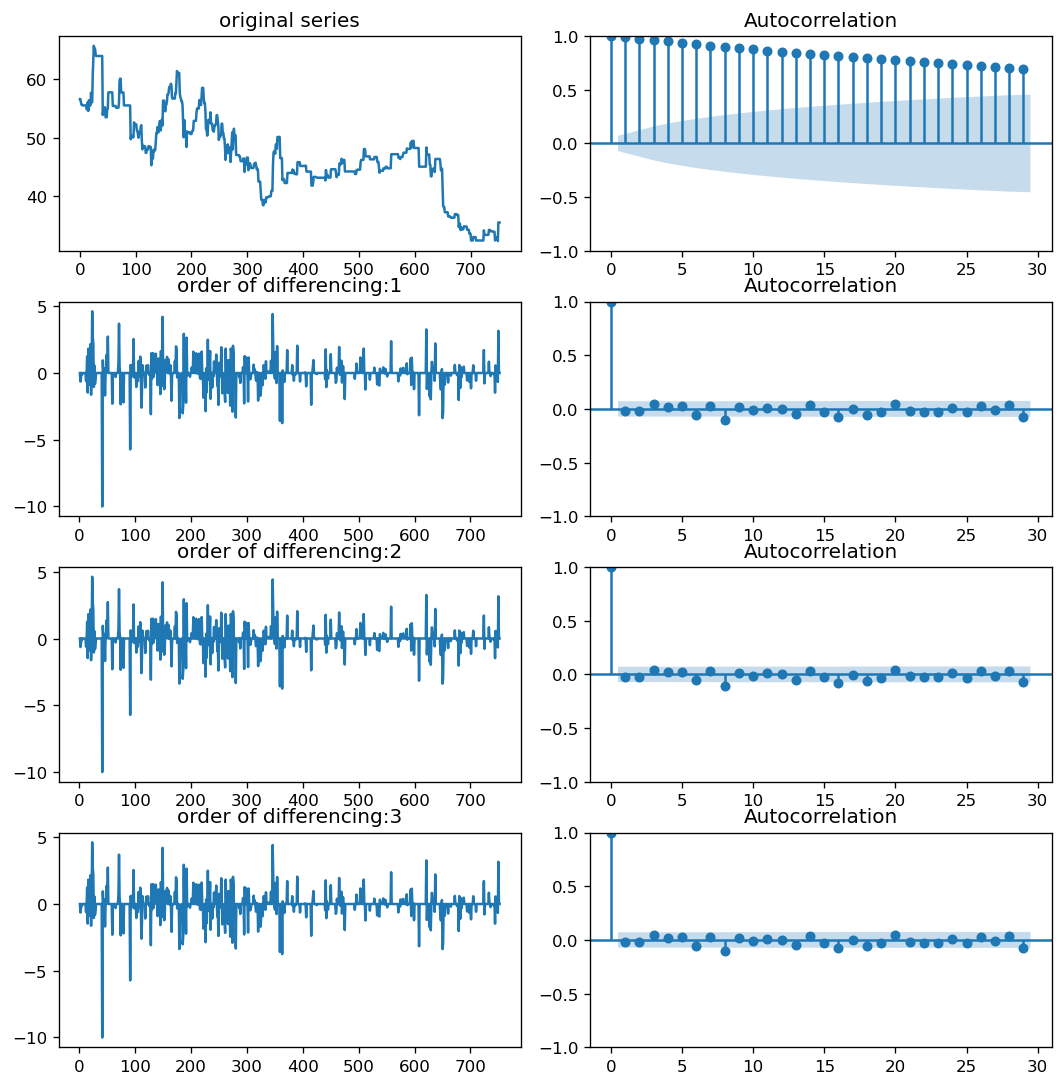

In [12]:
ndiff_list, var_diff_df = diff_order(train_data['Adj Close'])

It looks like that we just need to differencing the variable once (1st order) to get a `d=0`, which essentially suggests stationarity of the dataset. We can double check this by repeated the DickeyFuller on the 1st-order differenced dataset.

In [13]:
d = 1

DickeyFuller(var_diff_df[str(d)])

Results of Dickey-Fuller test

Test Statistics               -1.047755e+01
p-value                        1.237731e-18
No. of lags used               7.000000e+00
Number of observations used    7.440000e+02
critical value (1%)           -3.439170e+00
critical value (5%)           -2.865433e+00
critical value (10%)          -2.568843e+00
dtype: float64

With p < .05, we reject the null hypothesis and conclude that the data is stationary.


For this reason, I will be using the 1st-order differenced variable.

In [14]:
y = var_diff_df[str(d)]

### Finding `p`

The ‘p’ term is the order of the ‘Auto Regressive’ (AR) term, and refers to the number of lags of Y to be used as predictors. The required value of `p` can be deducted via partial autocorrelation between the series and its lag, after excluding the contributions from the intermediated lags.

In [15]:
def p_order(variable, max_order=3):

  var_diff_df = pd.DataFrame()

  fig, axes = plt.subplots(max_order, 2, sharex=False)
  fig.tight_layout()
  
  for i in range(max_order):
    var_diff = differencing(variable)

    # differencing
    axes[i, 0].plot(var_diff); axes[i, 0].set_title('order of differencing:' + str(i+1))
    plot_pacf(var_diff, ax=axes[i, 1])

    var_diff_df[str(i+1)] = var_diff

  return var_diff_df

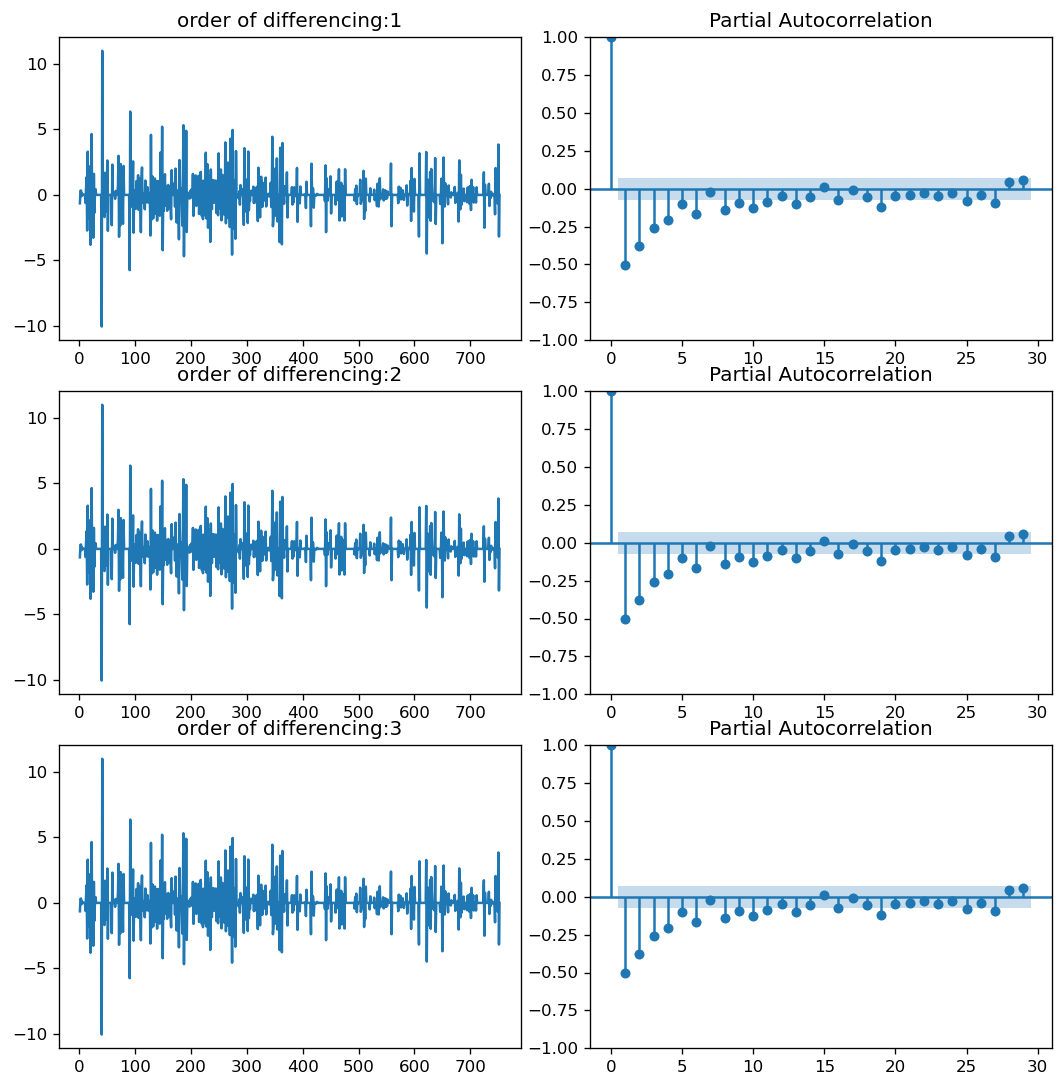

In [16]:
var_diff_df = p_order(y, max_order=3)

We can see that the partial autocorrelation values in the 1st differencing order are very similar to the values in the other orders, so I am going to be conservating and choose `p = 1`.

In [17]:
p = 1

### Finding `q`

The `q` term is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA. To find `q`, we can use the ACF plot from above (reposted below), which will tell us how much moving average is required to remove the autocorrelation from the stationary time series.

estimated difference for d = 1: 0


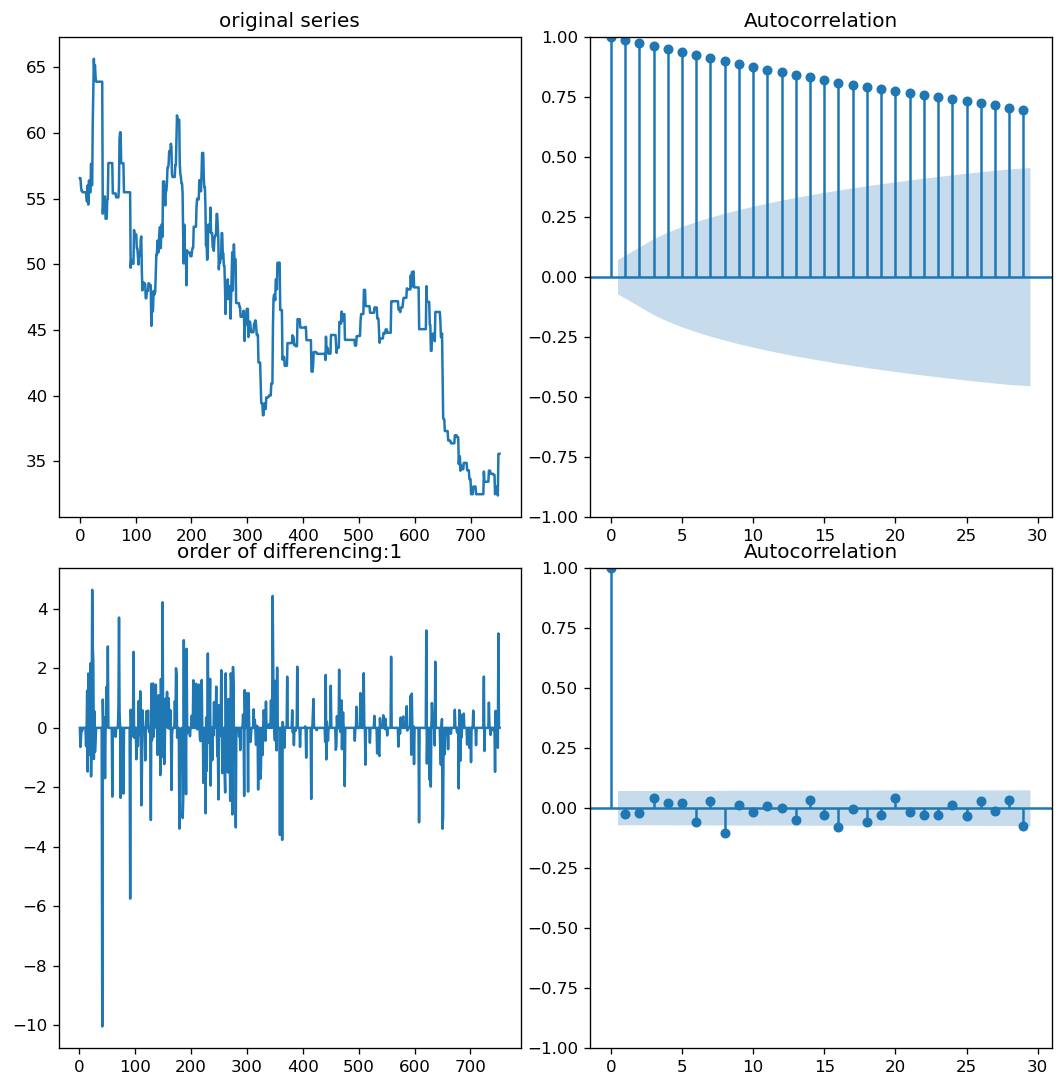

In [18]:
_, var_diff_df = diff_order(train_data['Adj Close'], max_order=d)

Here we can see that only 1 of the lags is out of the significance limit so I will set the optimal value for q accordingly

In [19]:
q = 1

### Building the ARIMA model

In [20]:
arima_model = ARIMA(train_data['Adj Close'], order=(p, d, q))
arima_fit = arima_model.fit()

We can now take a look at the residuals to see how well the model fit the data. If the residuals (or errors) of an ARIMA model are close to zero, it suggests that the model is fitting the data well, and the predictions are accurate. Ideally, in a well-fitted ARIMA model, the residuals should be random and have a mean close to zero.

In [21]:
# plotting residual errors
arima_residuals = pd.DataFrame(arima_fit.resid)

px.histogram(arima_residuals, nbins=50, labels={'x':'residuals', 'y':'count'})

In [22]:
px.box(arima_residuals, labels={'x':'residuals'})

The plots above show that the residuals were all very close to 0, thus suggesting that the model fit the data really well. 

### Evaluation

When evaluating an ARIMA model, a rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. One way to perform this is to re-create the ARIMA model after each new observation is received, so to keep track of the predictions of each true observations of the test set.

In [23]:
history_train = list(train_data['Adj Close'].copy(deep=True))
history_test = list(test_data['Adj Close'].copy(deep=True))

predictions = []

for i in range(len(test_data)):
  model = ARIMA(history_train, order=(p,d,q))
  fit = model.fit()
  output = fit.forecast()
  yhat = output[0]
  obs = history_test[i]

  predictions.append(yhat)
  history_train.append(obs)

  print('predicted=%f, expected=%f' % (yhat, obs))
  

predicted=35.582517, expected=35.584717
predicted=35.584335, expected=36.008343
predicted=35.998186, expected=36.008343
predicted=36.006618, expected=35.535458
predicted=35.546418, expected=35.535458
predicted=35.537371, expected=35.535458
predicted=35.535792, expected=35.535458
predicted=35.535515, expected=35.535458
predicted=35.535468, expected=37.830929
predicted=37.776209, expected=37.830929
predicted=37.821417, expected=37.830929
predicted=37.829270, expected=37.830929
predicted=37.830640, expected=37.830929
predicted=37.830880, expected=37.830929
predicted=37.830920, expected=37.830929
predicted=37.830927, expected=37.830929
predicted=37.830929, expected=37.830929
predicted=37.830929, expected=39.407219
predicted=39.369935, expected=37.614189
predicted=37.655953, expected=37.614189
predicted=37.621314, expected=37.614189
predicted=37.615408, expected=37.830929
predicted=37.825219, expected=37.525524
predicted=37.532911, expected=40.687950
predicted=40.598826, expected=40.550026


predicted=43.997443, expected=43.998158
predicted=43.996803, expected=44.008007
predicted=44.007518, expected=44.008007
predicted=44.007931, expected=42.372608
predicted=42.419105, expected=42.687870
predicted=42.686040, expected=42.687870
predicted=42.687590, expected=42.687870
predicted=42.687827, expected=39.574696
predicted=39.665088, expected=39.604256
predicted=39.617245, expected=39.407219
predicted=39.414755, expected=38.609219
predicted=38.632952, expected=38.609219
predicted=38.612603, expected=38.609219
predicted=38.609702, expected=38.609219
predicted=38.609288, expected=38.944183
predicted=38.934676, expected=38.944183
predicted=38.942826, expected=41.377579
predicted=41.308579, expected=41.377579
predicted=41.368332, expected=41.377579
predicted=41.376317, expected=41.377579
predicted=41.377408, expected=41.377579
predicted=41.377555, expected=39.082108
predicted=39.146523, expected=38.224998
predicted=38.254769, expected=38.224998
predicted=38.229097, expected=38.799999


Next, we can calculate the final root meean squared error (RMSE) and plot the true and the predicted values.

Test RMSE: 0.963


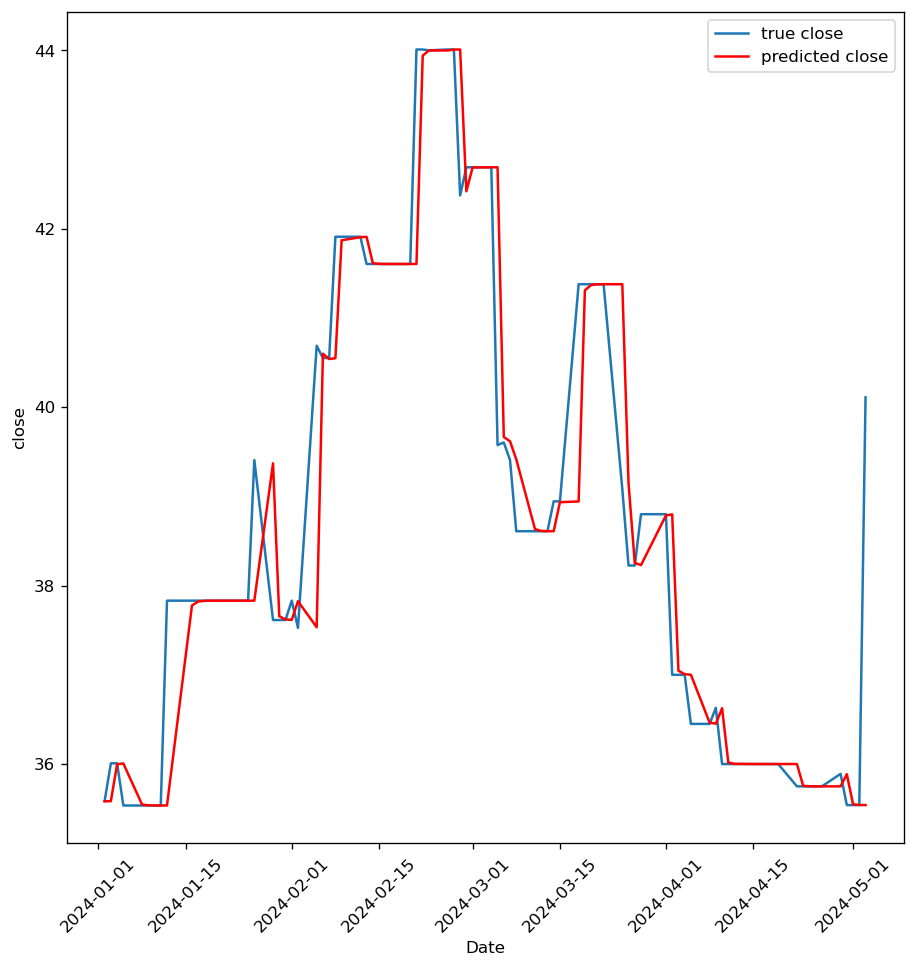

In [24]:
rmse = np.sqrt(mean_squared_error(history_test, predictions))
print('Test RMSE: %.2f' % rmse)

plt.plot(test_data['Date'], history_test, label='true close')
plt.plot(test_data['Date'], predictions, color='red', label='predicted close')
plt.legend()
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('close')
plt.show()

Both the rather RMSE score and the plot above suggest that the ARIMA algorithm has quite satisfactorily predicted the close prices. 

### Training through Grid-Search

The ARIMA model for time series analysis and forecasting can be tricky to set up, since it rests upon the estimation of three paramenters (`p, d, q`) that is usually made through rather subjective interpretation of diagnostics plots and heuristic rules. One way to automate hyperparameter selection and fine-tuning for ARIMA models is to implement a grid-search-like procedure from scratch. 

In [138]:
def rmse_arima(train_set, test_set, order):
  history_train = list(train_set['Adj Close'].copy(deep=True))
  history_test = list(test_set['Adj Close'].copy(deep=True))

  # build model and calculate predictions
  predictions = []
  for i in range(len(test_data)):
    model = ARIMA(history_train, order=order)
    fit = model.fit()
    output = fit.forecast()
    yhat = output[0]
    obs = history_test[i]

    predictions.append(yhat)
    history_train.append(obs) 

  # calculate RMSE
  rmse = np.sqrt(mean_squared_error(history_test, predictions))

  return rmse

def evaluate_arimas(train_set, test_set, ps, ds, qs):
  warnings.filterwarnings("ignore")
  best_score, best_order = float("Inf"), None
  for p in ps:
    for d in ds:
      for q in qs:
        order = (p, d, q)

        try:
          rmse = rmse_arima(train_set, test_set, order)
          if rmse < best_score:
            best_score, best_order = rmse, order
          print("ARIMA%s, RMSE = %.2f" % (order, rmse))
        except:
          continue
        
  print("Best model: ARIMA%s, RMSE = %.2f" % (best_order, best_score))

ps = np.arange(0, 3)
ds = np.arange(0, 3)
qs = np.arange(0, 3)
evaluate_arimas(train_data, test_data, ps=ps, ds=ds, qs=qs)

ARIMA(0, 0, 0), RMSE = 8.33
ARIMA(0, 0, 1), RMSE = 4.50
ARIMA(0, 0, 2), RMSE = 2.86
ARIMA(0, 1, 0), RMSE = 0.96
ARIMA(0, 1, 1), RMSE = 0.96
ARIMA(0, 1, 2), RMSE = 0.96
ARIMA(0, 2, 0), RMSE = 1.30
ARIMA(0, 2, 1), RMSE = 0.97
ARIMA(0, 2, 2), RMSE = 0.97
ARIMA(1, 0, 0), RMSE = 0.96
ARIMA(1, 0, 1), RMSE = 0.96
ARIMA(1, 0, 2), RMSE = 0.96
ARIMA(1, 1, 0), RMSE = 0.96
ARIMA(1, 1, 1), RMSE = 0.96
ARIMA(1, 1, 2), RMSE = 0.97
ARIMA(1, 2, 0), RMSE = 1.14
ARIMA(1, 2, 1), RMSE = 0.97
ARIMA(1, 2, 2), RMSE = 0.96
ARIMA(2, 0, 0), RMSE = 0.96
ARIMA(2, 0, 1), RMSE = 0.96
ARIMA(2, 0, 2), RMSE = 0.96
ARIMA(2, 1, 0), RMSE = 0.96
ARIMA(2, 1, 1), RMSE = 0.97
ARIMA(2, 1, 2), RMSE = 0.95
ARIMA(2, 2, 0), RMSE = 1.07
ARIMA(2, 2, 1), RMSE = 0.97
ARIMA(2, 2, 2), RMSE = 0.96
Best model: ARIMA(2, 1, 2), RMSE = 0.95


The best model detected in the Grid Seach process (with `p=2, d=1, q=2`) has a RMSE that is only 0.01 smaller than the model selected with the heuristic method (with `p=1, d=1, q=1`), which suggests that the two models are essentially identical. 

## Seasonal Autoregressive Integrated Moving Average (SARIMA)

SARIMA is an extension to ARIMA that supports direct modeling of the seasonal component of the time series. To this end, in addition to the `p, d, q` terms, SARIMA additional requires three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as one additional parameter for the period of the seasonality:

- `P`: the seasonal autoregressive order term
- `D`: the seasonal difference order term
- `Q`: the seasonal moving average order term
- `m`: the number of time steps for a single seasonal period

In the following, I will implement a grid-search procedure to find the best values for this parameters (instead of going through each parameter and follow the usual heuristics).

In [143]:
def rmse_sarima(train_set, test_set, params, debug=False):
  history_train = list(train_set['Adj Close'].copy(deep=True))
  history_test = list(test_set['Adj Close'].copy(deep=True))

  # build model and calculate predictions
  predictions = []
  for i in range(len(test_data)):
    order, seasonal_order, trend = params
    model = SARIMAX(history_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    fit = model.fit(disp=False)
    output = fit.forecast()
    yhat = output[0]
    obs = history_test[i]

    predictions.append(yhat)
    history_train.append(obs) 

    rmse = None
    str_params = str(params)
  
    if debug: 
      rmse = np.sqrt(mean_squared_error(history_test, predictions))
    else:
      try:
        with catch_warnings():
          filterwarnings("ignore")
          rmse = np.sqrt(mean_squared_error(history_test, predictions))
      except:
          rmse = None
      if rmse is not None:
        print("SARIMA%s, RMSE = %.2f" % (str_params, rmse))
    
  return str_params, rmse

# create the set of parameters to feed into the model
def sarima_params(ps, ds, qs, Ps, Ds, Qs, ms):
  params_list = []
  ts = ['n','c','t','ct']
  
  for p in ps:
    for d in ds:
      for q in qs:
        for t in ts:
          for P in Ps:
            for D in Ds:
              for Q in Qs:
                for m in ms:
                  params = [(p, d, q), (P, D, Q, m), t]
                  params_list.append(params)
  
  return params_list

def evaluate_sarimas(train_set, test_set, params_list):
  scores = [rmse_sarima(train_set, test_set, params) for params in params_list]
  scores = [score for score in scores if score[1] != None] # remove empty results
  scores.sort(key=lambda score: score[1])

  return scores

To avoid CPU overload, I will just use the same `p, d, q` values used above for both seasonal and non-seasonal orders, and introduce the trend (`t`, which can be either `t`, for linear trend; `c` for constant; or `ct`, both) and `m` variables (which is typically 7 or 12 -- i.e., daily, or monthly) in the equation to check if a model that takes into account seasonality is better. 

In [144]:
ps = [p]
ds = [d]
qs = [q]
Ps = [p]
Ds = [d]
Qs = [q]
ms = [7, 12] # any shorter cycle (e.g., weekly or daily might be problematics for SARIMA)
params_list = sarima_params(ps, ds, qs, Ps, Ds, Qs, ms)

sarimas_scores = evaluate_sarimas(train_data, test_data, params_list)

SARIMA[(1, 1, 1), (1, 1, 1, 7), 'n'], RMSE = 0.98
SARIMA[(1, 1, 1), (1, 1, 1, 12), 'n'], RMSE = 0.98
SARIMA[(1, 1, 1), (1, 1, 1, 7), 'c'], RMSE = 0.98
SARIMA[(1, 1, 1), (1, 1, 1, 12), 'c'], RMSE = 0.98
SARIMA[(1, 1, 1), (1, 1, 1, 7), 't'], RMSE = 1.06
SARIMA[(1, 1, 1), (1, 1, 1, 12), 't'], RMSE = 1.03
SARIMA[(1, 1, 1), (1, 1, 1, 7), 'ct'], RMSE = 1.05
SARIMA[(1, 1, 1), (1, 1, 1, 12), 'ct'], RMSE = 1.04


The Grid Search algorithm identified that the SARIMA model can quite successfully predict the close price, with a fairly low RMSE. In particular, a few minimally different parameter combinations are reported to have a RMSE that is very close (but 0.02 higher than) the RMSE of the ARIMA model. This suggests that taking into account seasonality and trends might not be useful for our specific case after all. 

Lastly, I will try out the `auto_arima()` function from the `pmdarima` library, which automatically performs a parameter search for optimal values similar to the one above, just to compare the results.

In [161]:
sarima_model = auto_arima(train_data["Adj Close"], 
                          m=12, #12 is the frequency of the cycle
                          d=None, # let model determine 'd'
                          test='adf', # use adftest to find optimal 'd'
                          start_p=0, start_q=0, # minimum p and q
                          max_p=3, max_q=3, # maximum p and q
                          start_P=0, start_Q=0,
                          seasonal=True, #set to seasonal
                          D=1, # let model determine 'D'
                          trace=True,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

print(sarima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3873.764, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2350.045, Time=0.46 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=3131.228, Time=0.56 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3880.287, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=2558.524, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=2286.373, Time=1.49 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.87 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=3804.748, Time=0.87 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=2288.371, Time=1.34 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=2288.370, Time=1.51 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=3134.234, Time=1.18 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=2290.371, Time=1.73 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=2284.954, Time=0.46 sec
 ARIMA(1,0,0)(1,1,0)[12]     

In [162]:
sarima_model.fittedvalues()

0       0.000000
1       0.000470
2       0.000886
3       0.001246
4       0.001553
         ...    
748    33.616360
749    32.836124
750    32.463799
751    35.469012
752    35.469012
Length: 753, dtype: float64

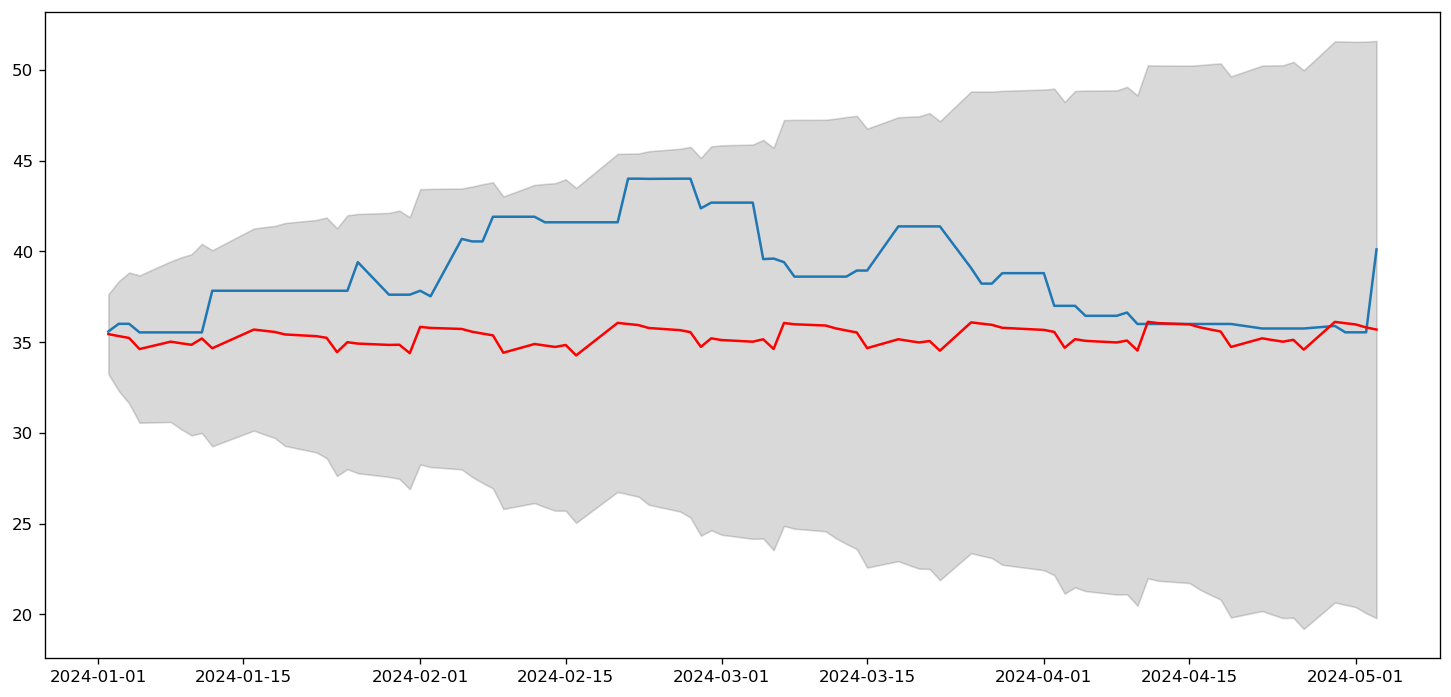

RMSE: 4.23


In [160]:
def forecast(model, periods=len(test_data)):
    # Forecast
    n_periods = periods
    predictions, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    date = test_data['Date']

    rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], predictions))

    # make series for plotting purpose
    predictions_pd = pd.DataFrame(predictions).set_index(date)
    lower_pd = pd.DataFrame(confint[:, 0]).set_index(date)
    upper_pd = pd.DataFrame(confint[:, 1]).set_index(date)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(test_data['Date'], test_data['Adj Close'])
    plt.plot(predictions_pd, color='red')
    plt.fill_between(lower_pd.index, 
                     lower_pd[0], 
                     upper_pd[0], 
                     color='k', alpha=.15)
    plt.show()

    print("RMSE: %.2f" % rmse)
    
forecast(sarima_model)

Similar to the standard ARIMA and SARIMA algorithms, the Auto (S)ARIMA algorithm is able to give reliable predictions on the test data. This can be clearly seen from the fact that the actual values from test data is within the confidence intervals calculated from the coefficient of the model. Admittedly, the confidence span is relatively large (and increases progressively in time), thus making the predictions less precise.

## Exponential Smoothing (ES)

Exponential smoothing is a method similar to the previous one in that a prediction is a weighted sum of past observations. Unlike those, it involves an exponentially decreasing weight for past observations. There are three main types of exponential smoothing:

1. A simple method that assumes no systematic structure;
2. A slightly more complex method that explicitly handles trends;
3. An advanced approach that add support for seasonality.

Since previous analyses suggested no dramatic change when implementing trends and seasonality, I will just try out the simplest method (*single exponential smoothing*).

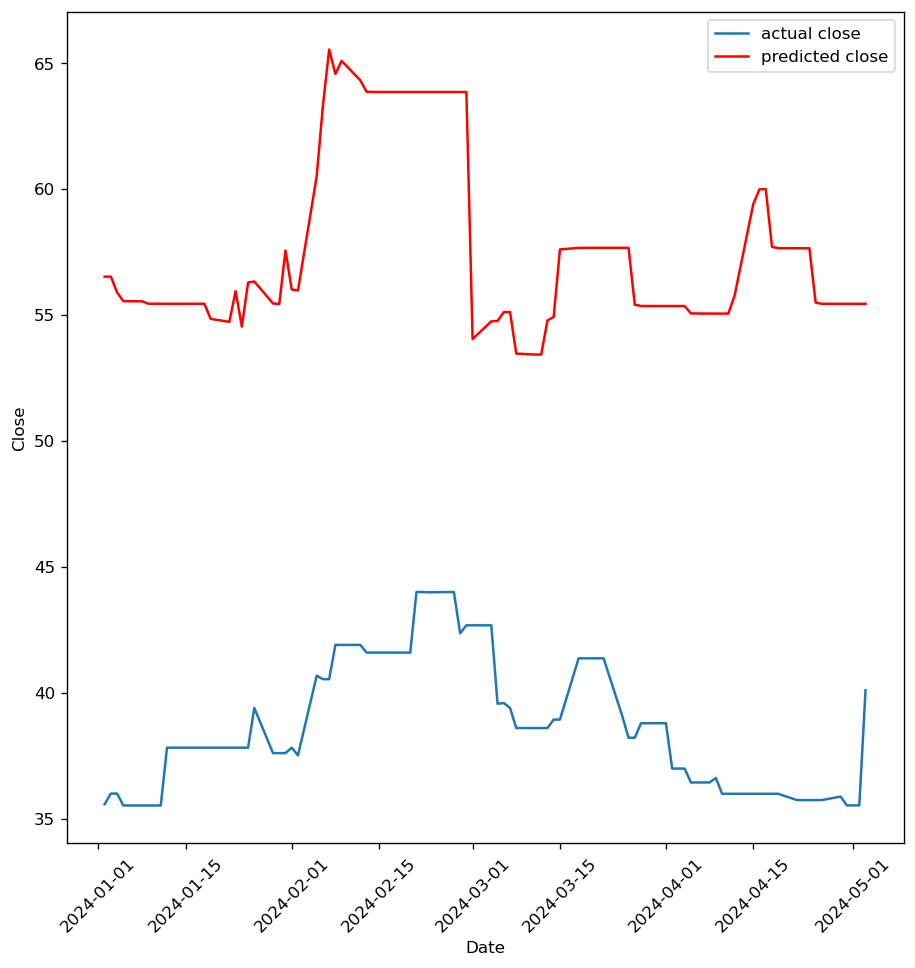

RMSE: 19.20


In [204]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

exp_model = SimpleExpSmoothing(train_data['Adj Close'])
exp_fit = exp_model.fit(optimized=True, remove_bias=True)
exp_yhat = exp_fit.predict(start=1, end=len(test_data))

plt.plot(test_data['Date'], test_data['Adj Close'], label='actual close')
plt.plot(test_data['Date'], exp_yhat, label='predicted close', color='red')
plt.xlabel("Date"), plt.ylabel("Close"), plt.xticks(rotation=45), plt.legend()
plt.show()

exp_rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], exp_yhat))
print("RMSE: %.2f" % exp_rmse)

The (simple) Exponential Smoothing seems unable to make right predictions for the dataset at hand.

## Prophet

Facebook Prophet is an accurate and fast to generate predictions for time series data. It works with missing data, and does not need to perform sophisticated data preprocessing, while still ensure reliable predictions.
Prophet only needs the independent and dependent variables, which need to be renames to be properly read and used for modelling.

In [207]:
train_data_prophet = train_data[['Date', 'Adj Close']]
train_data_prophet = train_data_prophet.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

test_data_prophet = test_data[['Date', 'Adj Close']]
test_data_prophet = test_data_prophet.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

In [210]:
# creating the prophet model

prophet = Prophet(daily_seasonality=True)
prophet.fit(train_data_prophet)

prophet_df = prophet.make_future_dataframe(periods=len(test_data)) # creates a dataframe that extends into the future a specified number of days
prophet_forecast = prophet.predict(prophet_df)

08:07:35 - cmdstanpy - INFO - Chain [1] start processing
08:07:35 - cmdstanpy - INFO - Chain [1] done processing


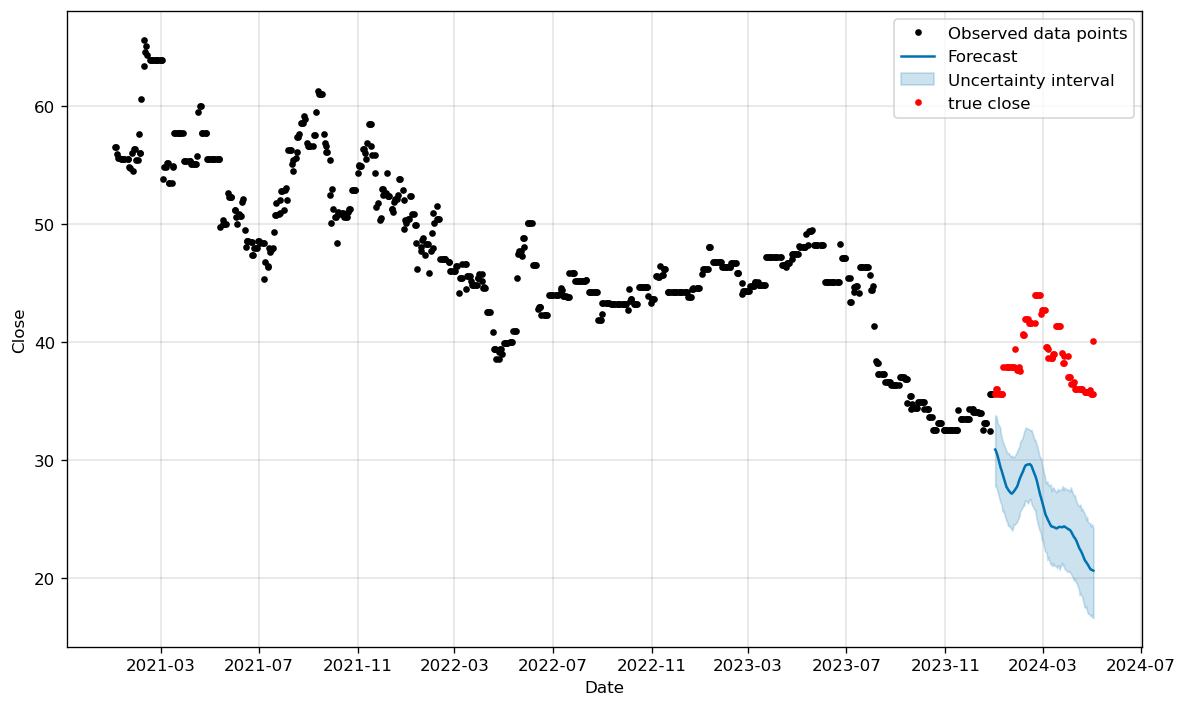

In [215]:
# plot the time series 
forecast_plot = prophet.plot(prophet_forecast)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
predictions = prophet_forecast['ds'].iloc[-len(test_data)]
# plot true test data for the period after the red line
plt.plot(test_data_prophet['ds'], test_data_prophet['y'],'ro', markersize=3, label='true close')
plt.xlabel("Date"), plt.ylabel("Close"), plt.legend(), plt.show();

In [216]:
from statsmodels.tools.eval_measures import rmse

predictions = prophet_forecast.iloc[-len(test_data):]['yhat']
actuals = test_data['Adj Close']

print(f"RMSE: {round(rmse(predictions, actuals))}")

RMSE: 13


The Prophet algorithm seems to perform worse than the autoregression-based models above (and similarly to the ES algorithm).

## LSTM

In [300]:
def create_sequences(df, x_window=5, y_window=5):
  array = np.array(df)
  
  X = []
  y = []

  for i in range(len(array) - x_window - y_window):
    X.append(array[i : i+x_window])
    y.append(array[i+x_window : i+x_window+y_window])
  
  return np.array(X), np.array(y)

In [301]:
x_window, y_window = 5, 5

train_X, train_y = create_sequences(train_data['Adj Close'], x_window=x_window, y_window=y_window)
test_X, test_y = create_sequences(test_data['Adj Close'], x_window=x_window, y_window=y_window)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((743, 5), (743, 5), (76, 5), (76, 5))

In [297]:
lstm_model = Sequential([
  InputLayer((train_X.shape[1], 1)),
  LSTM(64, return_sequences=True),
  Dropout(0.1),
  LSTM(64),
  Dense(128, 'relu'),
  Dense(64, 'relu'),
  Dense(5, 'linear')
], name='LSTM_model')

lstm_model.compile(loss=MeanSquaredError(), 
                   optimizer=Adam(learning_rate=0.001), 
                   metrics=[RootMeanSquaredError()])

lstm_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 64)             16896     
                                                                 
 dropout_17 (Dropout)        (None, 5, 64)             0         
                                                                 
 lstm_36 (LSTM)              (None, 64)                33024     
                                                                 
 dense_51 (Dense)            (None, 128)               8320      
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 5)                 325       
                                                                 
Total params: 66,821
Trainable params: 66,821
Non-traina

In [298]:
lstm_model.fit(train_X, train_y, epochs=100, validation_data=(train_X, train_y))

Epoch 1/100


24/24 [==============================] - 4s 39ms/step - loss: 2086.8582 - root_mean_squared_error: 45.6821 - val_loss: 1674.1934 - val_root_mean_squared_error: 40.9169
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 948.0681 - root_mean_squared_error: 30.7907 - val_loss: 213.1349 - val_root_mean_squared_error: 14.5991
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 112.6435 - root_mean_squared_error: 10.6134 - val_loss: 53.9317 - val_root_mean_squared_error: 7.3438
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 54.4312 - root_mean_squared_error: 7.3778 - val_loss: 50.8146 - val_root_mean_squared_error: 7.1284
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 50.4816 - root_mean_squared_error: 7.1050 - val_loss: 49.5171 - val_root_mean_squared_error: 7.0368
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 48.9049 - root_mean_squared_error: 6.9932 - val_loss: 47.8649

The LSTM model seems able to provide fairly good predictions on the close price (though its predictions looks a bit "staggered" in time, and might not be timely).

# Bollinger Bands

# Conclusions